# Level density analysis

In [1]:
import numpy as np
import spectrumtools as spt
import matplotlib.pyplot as plt
import leveldensities as ldn

plt.rc('font',size=16)

### Notes

**Select a file for analysis.**

Plot out the data and a region of interest.

data input from  /Users/rogerfearick/Desktop/research/linax/datastore/Sm154/data_154Sm_all_5keV.dat


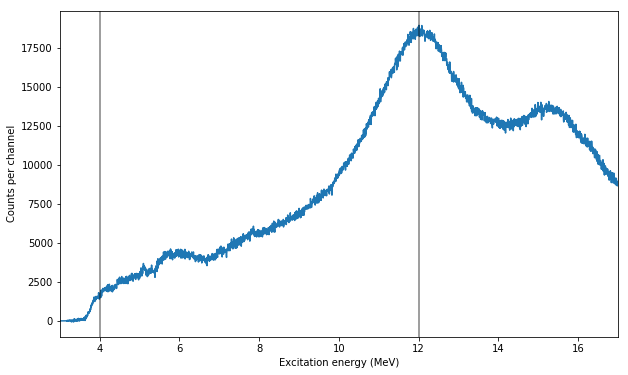

In [2]:
nucleus="154Sm"
xnucleus=nucleus[3:]+nucleus[0:3]  # fiddle name and A !
path=spt.findstore(xnucleus)

angle=0.4
lump=1
targetfilename="data_154Sm_all_5keV.dat"
# at 5 keV / channel
ROIlo,ROIhi=(40*5,360*5)  # 1600 chans: 200 - 1800
        
#ROIlo=ROIlo+50
#ROIhi=ROIhi+50
        
# *** Read in data
try:
    print("data input from ",path+targetfilename)
    e,cs0=np.loadtxt(path+targetfilename,unpack=True,usecols=(0,1))
    de=e[2]-e[1]
    # energy in MeV: find kev/ch as int
    intde=int(de*1000.0+0.1)
    G=cs0
    X=e
except:
    raise(ValueError,("File not found"))

plt.figure(figsize=(10,6))
plt.plot(e,cs0)
elo=e[ROIlo]
ehi=e[ROIhi]
plt.axvline(elo,color='k',alpha=0.5)
plt.axvline(ehi,color='k',alpha=0.5)
plt.xlim(3.0,17.0)
plt.xlabel("Excitation energy (MeV)")
plt.ylabel("Counts per channel")
plt.show()

**Create analysis objects.**

Plot out the stationary spectrum for both no narrow smooth, and a narrow smooth.

sig=0.0139  sigsm= 0.0486 sigsmn= 0.0130 MeV


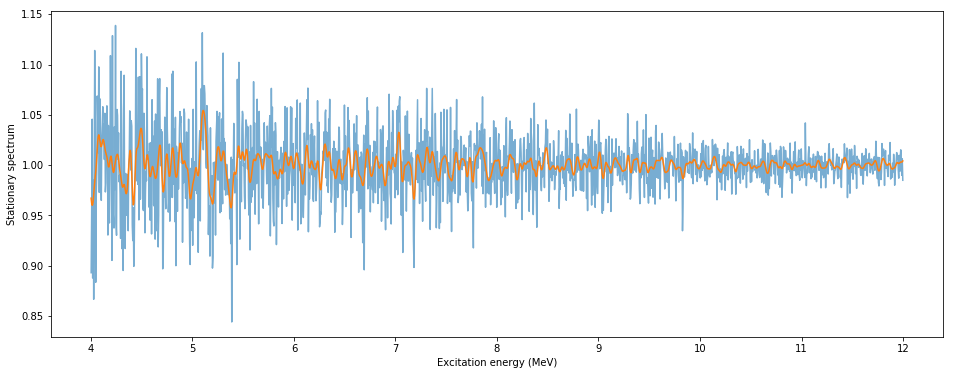

In [3]:
# (28/6/2018) unweighted average fwhm is 32.6 keV from AK spreadsheet.
sig = 32.6/2.35/1000.0
#sig = 40.0/2.35/1000.0
#sig=50.0/2.35/1000.0
sigsm=3.5*sig
sigsmn=0.4*2.35*sig
sigx=sigsm*2.5
print("sig=%6.4f  sigsm=%7.4f sigsmn=%7.4f MeV"%(sig,sigsm,sigsmn))

S=spt.RatioSpectrum( X, G, targetfilename, ROIlo, ROIhi )
globalenergy = S.energy

S.makeRatioSpectra( sigsmn*1000, sigsm*1000 )

Eratio=S.Eratio
ratioraw=S.ratioraw
rationar=S.rationar

plt.figure(figsize=(16,6))
plt.plot(Eratio, ratioraw, alpha=0.6)
plt.plot(Eratio, rationar)
plt.xlabel("Excitation energy (MeV)")
plt.ylabel("Stationary spectrum")
plt.show()

In [20]:
#bins=spt.ACBinner(S,Noffset=2,Nslides=2)
bins=spt.ACBinner(S,NAC=4,Nslides=2)
print("Computed bin limits:\n",bins.get_bins())

Computed bin limits:
 [(0, 400), (200, 600), (400, 800), (600, 1000), (800, 1200), (1000, 1400), (1200, 1600)]


**Select a dataset to illustrate a typical analysis.**

Plot out the autocorrelation for the non-smoothed and smoothed cases.

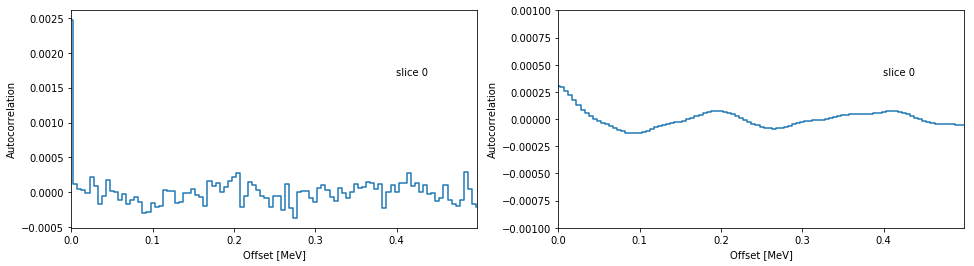

In [21]:
binlist=bins.get_bins()
index=0
l,h=binlist[index]
#print("Bin limits: %8.3f .. %8.3f MeV"%bins.get_bin_limits(index))
bin=spt.Bin(bins.data,l,l+(h-l)//2)
bin=spt.Bin(bins.data,l,h)
energy=bin.Eoffset
data=bin.acnar
plt.figure(figsize=(16,4))
plt.subplot(121)
#plt.plot(energy, data, drawstyle='steps-mid')
plt.plot(energy,bin.acraw, drawstyle='steps-mid')
yl,yh=plt.ylim()
plt.xlim(0.0,energy[-1]/4)
plt.text(0.8,0.7,"slice %d"%index,transform=plt.gca().transAxes)
plt.xlabel("Offset [MeV]")
plt.ylabel("Autocorrelation")
plt.subplot(122)
plt.plot(energy, data, drawstyle='steps-mid')
plt.xlim(0.0,energy[-1]/4)
plt.text(0.8,0.7,"slice %d"%index,transform=plt.gca().transAxes)
plt.xlabel("Offset [MeV]")
plt.ylabel("Autocorrelation")
plt.ylim(yl,yh)
plt.ylim(-0.001,0.001)
plt.show()

### **Try the usual analysis**

**1. Set up for fit**

In [22]:
import lmfit

sign=np.sqrt(sig**2+sigsmn**2)
sigw=np.sqrt(sig**2+sigsm**2)

def fitforlm( params, e, data, unc=None ):
    """
    fit function for least sq fit using lmfit
    """
    global alpha
    p=params.valuesdict()
    D=p['D']
    sign=p['sign']
    sigw=p['sigw']
    sigx=p['sigx']
    ys=sigw/sign
    ysp=1.+ys*ys
    sig=sign
    model=(1.0/(2.0*np.sqrt(np.pi)*sig))*(alpha*D)*np.exp(-e*e/(4.*sig*sig))
    model+=(1.0/(2.0*np.sqrt(np.pi)*sig*ys))*(alpha*D)*np.exp(-e*e/(4.*sig*sig*ys*ys))
    model-=(1.0/(2.0*np.sqrt(np.pi)*sig))*(alpha*D)*np.sqrt(8./ysp)*np.exp(-e*e/(2.*sig*sig*ysp))
    model*=np.exp(-e*e/(2.0*sigx**2))
    if unc is None:
        unc=np.ones(len(data))
    return (model-data)/unc

def model(params, e):
    p=params.valuesdict()
    D=p['D']
    sign=p['sign']
    sigw=p['sigw']
    sigx=p['sigx']
    ys=sigw/sign
    ysp=1.+ys*ys
    sig=sign
    model=(1.0/(2.0*np.sqrt(np.pi)*sig))*(alpha*D)*np.exp(-e*e/(4.*sig*sig))
    model+=(1.0/(2.0*np.sqrt(np.pi)*sig*ys))*(alpha*D)*np.exp(-e*e/(4.*sig*sig*ys*ys))
    model-=(1.0/(2.0*np.sqrt(np.pi)*sig))*(alpha*D)*np.sqrt(8./ysp)*np.exp(-e*e/(2.*sig*sig*ysp))
    #model*=np.exp(-e*e/(2.0*sigx**2))
    return model

alpha=2.273


**2. Try a fit to one slice.**

In [23]:
initialD=data[0]*(2.0*np.sqrt(np.pi)*sig)/alpha
ndata=len(data)
params=lmfit.Parameters()
params.add('D',value=initialD, min=0.0)
params.add('sign',value=sign,min=0.0,vary=True)
params.add('sigw',value=sigw,min=0.0,vary=False)
params.add('sigx',value=sigx,vary=False)
noise=bin.get_noise_correction(sigsmn, sigsm)
uncert=np.linspace(data[0]/10,data[0]/5,ndata)
ACfx=(data)*np.exp(-energy**2/(2.0*sigx**2))
#ACfx=(data-noise)*np.exp(-energy**2/(2.0*sigx**2))
#initial=1.0
#popt,pcov=curve_fit(fitf2, Xac, ACf, p0=[initial,sig])
#sig=popt[1]
#popt[0]*=initialD
minner=lmfit.Minimizer(fitforlm, params, fcn_args=(energy,ACfx),
                       fcn_kws={'unc':uncert})
result=minner.minimize()
lmfit.printfuncs.report_fit(result.params)

p=result.params.valuesdict()
rho=1.0/p['D']
elo,ehi=bins.get_bin_limits(index)
en=(elo+ehi)/2
print(en,rho,1.0/initialD,p['sigw'],p['sign'],p['sigx'])

[[Variables]]
    D:      0.00048926 +/- 6.28e-05 (12.83%) (init= 6.528094e-06)
    sign:   0.04062284 +/- 0.000550 (1.35%) (init= 0.019039)
    sigw:   0.05049608 (fixed)
    sigx:   0.121383 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(D, sign)                   =  0.996 
5.0 2043.8870907717492 153184.0706872972 0.05049608135969041 0.04062284935219096 0.12138297872340427


**3. Plot results.**

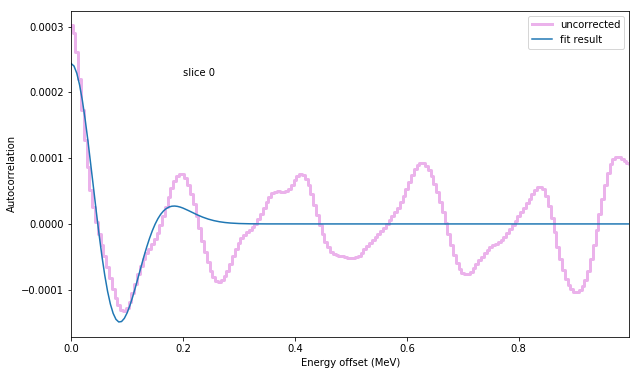

In [24]:
m=model(result.params, energy)
plt.figure(figsize=(10,6))
plt.plot(energy,data,'m-',lw=3.0,alpha=0.3, drawstyle='steps-mid',label="uncorrected")
#plt.plot(energy, data-noise,lw=2, drawstyle='steps-mid',label="corrected")
plt.xlim(0.0,energy[-1]/2)
plt.text(0.2,0.8,"slice %d"%index,transform=plt.gca().transAxes)
plt.plot(energy,m,label="fit result")
#de=(energy[1]-energy[0])*2
#sinc=de*np.sin(energy/(1.12*sign))/(energy/(1.2*sign))
#plt.plot(energy[1:],0.1*sinc[1:])
#plt.ylim(-0.0002,0.0004)
#plt.plot(energy,noise,label="noise correction")
#plt.plot(energy,m+noise,'k-',label="fit + noise")
plt.xlabel("Energy offset (MeV)")
plt.ylabel("Autocorrelation")
plt.legend()
plt.show()

**4. Now fit all slices and plot level densities.**

Here we also let sign vary.

0 0.0003017388006033824
1 0.0002057616552971419
2 0.0001123050010704403
3 7.82264855796177e-05
4 2.9209303135422703e-05
5 1.8348402890477315e-05
6 8.895040572979074e-06


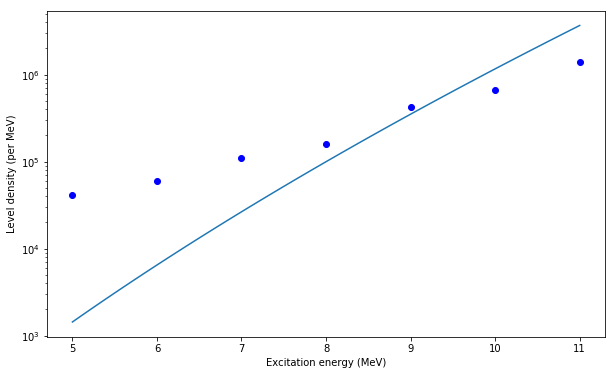

In [25]:
import leveldensities as ldn
rholist=[]
for i,(l,h) in enumerate(binlist):
    bini=spt.Bin(bins.data,l,h)
    energy=bini.Eoffset
    data=bini.acnar
    initialD=data[0]*(2.0*np.sqrt(np.pi)*sig)/alpha
    ndata=len(data)
    params=lmfit.Parameters()
    params.add('D',value=initialD, min=0.0)
    params.add('sign',value=sign,min=0.0, vary=True)
    params.add('sigw',value=sigw,min=0.0,vary=False)
    params.add('sigx',value=sigx,vary=False)
    uncert=np.linspace(data[0]/10,data[0]/5,ndata)
    ACfx=data*np.exp(-energy**2/(2.0*sigx**2))
    minner=lmfit.Minimizer(fitforlm, params, fcn_args=(energy,ACfx),
                           fcn_kws={'unc':uncert})
    result=minner.minimize()
    p=result.params.valuesdict()
    print(i,ACfx[0])
    D=ACfx[0]/spt.ACtheory(de,sign,sigw,alpha,1.0)
    rho=1.0/D #p['D']
    elo,ehi=bins.get_bin_limits(i)
    en=(elo+ehi)/2
    rholist.append((en,rho))
    
rholist=np.array( rholist )
# original method
eOrig=rholist.T[0]
rhoOrig=rholist.T[1]
# theory
Eth=np.linspace(5.0,11.0)
Z,N=62,154-62
Spin=1.0
rhoth=ldn.LevelDenvonEgidy(Eth, Z, N, Spin)
# plot
plt.figure(figsize=(10,6))
plt.semilogy(eOrig,rhoOrig,'bo')
plt.semilogy(Eth,rhoth,label="von Egidy")
plt.xlabel("Excitation energy (MeV)")
plt.ylabel("Level density (per MeV)")
plt.show()

**5. Section for Achim.**

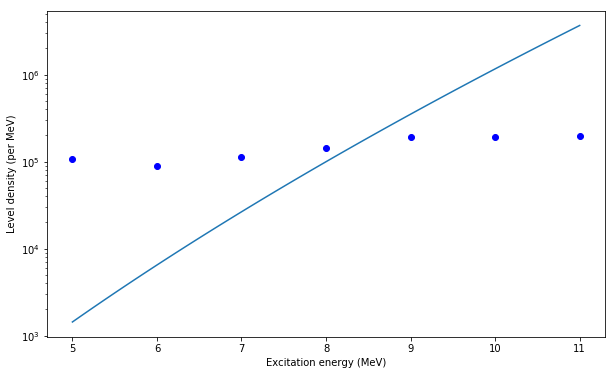

In [26]:
de=0.005 # bin width
alpha=2.273
rholist=[]
for i,(l,h) in enumerate(binlist):
    bini=spt.Bin(bins.data,l,h)
    energy=bini.Eoffset
    data=bini.acraw
    varn=bin.acraw[0]-bin.acraw[1]
    noisecorrectionnonsmooth=spt.ACnoise_nonsm(energy, sig, sigsm, de, varn)
    data=data-noisecorrectionnonsmooth
    AC1=np.mean(data[1:3]) # take this as the value of AC
    
    D=AC1/spt.ACtheory(de,sig,sigsm,alpha,1.0)
    rho=1.0/D
    elo,ehi=bins.get_bin_limits(i)
    en=(elo+ehi)/2
    rholist.append((en,rho))
    
rholist=np.array( rholist )
eAR=rholist.T[0]
rhoAR=rholist.T[1]
# theory
Eth=np.linspace(5.0,11.0)
Z,N=62,154-62
Spin=1.0
rhoth=ldn.LevelDenvonEgidy(Eth, Z, N, Spin)
# plot
plt.figure(figsize=(10,6))
plt.semilogy(eAR,rhoAR,'bo')
plt.semilogy(Eth,rhoth,label="von Egidy")
plt.xlabel("Excitation energy (MeV)")
plt.ylabel("Level density (per MeV)")
plt.show()

---
### **Let's look at the effect of noise.**

**1. Plot the noise corrections. **

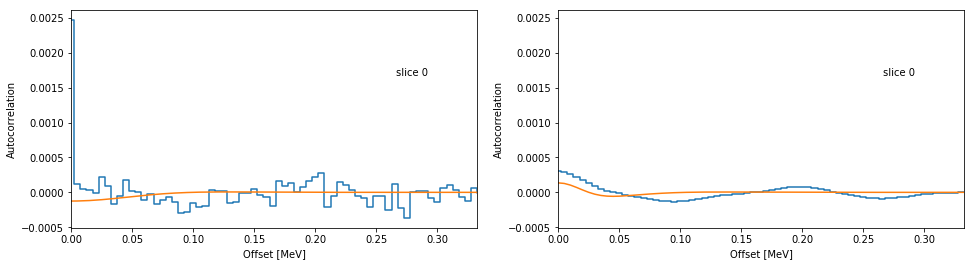

In [27]:
de=0.005 # bin width
energy=bin.Eoffset
data=bin.acnar
varn=bin.acraw[0]-bin.acraw[1]
noisecorrectionnonsmooth=spt.ACnoise_nonsm(energy, sig, sigsm, de, varn)
noisecorrection=spt.ACnoise(energy, sigsmn, sigsm, de, varn)
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(energy,bin.acraw, drawstyle='steps-mid')
plt.plot(energy,noisecorrectionnonsmooth)
yl,yh=plt.ylim()
plt.xlim(0.0,energy[-1]/6)
plt.text(0.8,0.7,"slice %d"%index,transform=plt.gca().transAxes)
plt.xlabel("Offset [MeV]")
plt.ylabel("Autocorrelation")
plt.subplot(122)
plt.plot(energy, data, drawstyle='steps-mid')
plt.plot(energy,noisecorrection)
plt.xlim(0.0,energy[-1]/6)
plt.text(0.8,0.7,"slice %d"%index,transform=plt.gca().transAxes)
plt.xlabel("Offset [MeV]")
plt.ylabel("Autocorrelation")
plt.ylim(yl,yh)
plt.show()

**2. Subtract the effect of noise.**

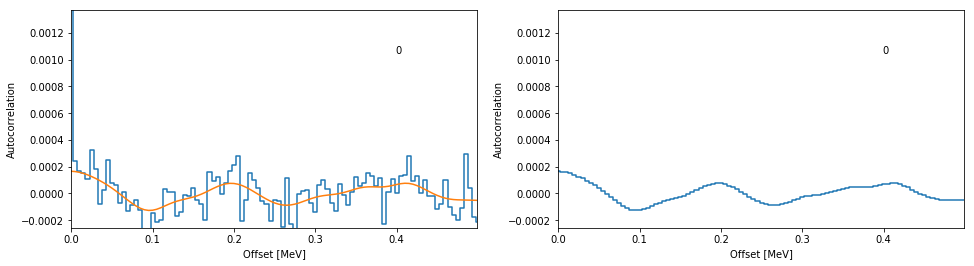

In [28]:
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(energy,bin.acraw-noisecorrectionnonsmooth, drawstyle='steps-mid')
plt.plot(energy, data-noisecorrection)
plt.xlim(0.0,energy[-1]/4)
plt.text(0.8,0.8,"%d"%index,transform=plt.gca().transAxes)
plt.xlabel("Offset [MeV]")
plt.ylabel("Autocorrelation")
yl,yh=plt.ylim()
plt.ylim(yl/2,yh/2)
plt.subplot(122)
plt.plot(energy, data-noisecorrection, drawstyle='steps-mid')
plt.xlim(0.0,energy[-1]/4)
plt.text(0.8,0.8,"%d"%index,transform=plt.gca().transAxes)
plt.xlabel("Offset [MeV]")
plt.ylabel("Autocorrelation")
plt.ylim(yl/2,yh/2)
plt.show()

In [29]:
# try optimise noise by matching these two
varn=bin.acraw[0]-bin.acraw[1]
print(varn)
fract=np.linspace(0.1,1.2,20)
N=len(bin.acraw//2)
for f in fract:
    noisecorrectionnonsmooth=spt.ACnoise_nonsm(energy, sig, sigsm, de, f*varn)
    noisecorrection=spt.ACnoise(energy, sigsmn, sigsm, de, f*varn)
    uncor=bin.acraw-noisecorrectionnonsmooth
    cor=data-noisecorrection
    chisq=np.sum((uncor[1:8]-cor[1:8])**2)
    #print(f, chisq) 

0.0023479080023184563


**3. Now try a fit.**

In [30]:
initialD=data[0]*(2.0*np.sqrt(np.pi)*sig)/alpha
ndata=len(data)
params=lmfit.Parameters()
params.add('D',value=initialD, min=0.0)
params.add('sign',value=sign,min=0.0,vary=False)
params.add('sigw',value=sigw,min=0.0,vary=False)
params.add('sigx',value=sigx,vary=False)
noise=bin.get_noise_correction(sigsmn, sigsm)
uncert=np.linspace(data[0]/10,data[0]/5,ndata)
#ACfx=(data)*np.exp(-energy**2/(2.0*sigx**2))
ACfx=(data-noise)*np.exp(-energy**2/(2.0*sigx**2))
#initial=1.0
#popt,pcov=curve_fit(fitf2, Xac, ACf, p0=[initial,sig])
#sig=popt[1]
#popt[0]*=initialD
minner=lmfit.Minimizer(fitforlm, params, fcn_args=(energy,ACfx),
                       fcn_kws={'unc':uncert})
result=minner.minimize()
lmfit.printfuncs.report_fit(result.params)

p=result.params.valuesdict()
rho=1.0/p['D']
elo,ehi=bins.get_bin_limits(index)
en=(elo+ehi)/2
print(en,rho,1.0/initialD,p['sigw'],p['sign'],p['sigx'])

[[Variables]]
    D:      1.1667e-05 +/- 6.34e-07 (5.43%) (init= 6.528094e-06)
    sign:   0.019039 (fixed)
    sigw:   0.05049608 (fixed)
    sigx:   0.121383 (fixed)
5.0 85710.26296544347 153184.0706872972 0.05049608135969041 0.019038997580803647 0.12138297872340427


**4. Plot fit results.**

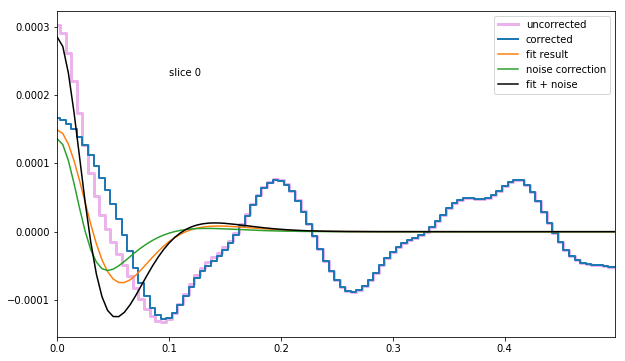

In [31]:
m=model(result.params, energy)
plt.figure(figsize=(10,6))
plt.plot(energy,data,'m-',lw=3.0,alpha=0.3, drawstyle='steps-mid',label="uncorrected")
plt.plot(energy, data-noise,lw=2, drawstyle='steps-mid',label="corrected")
plt.xlim(0.0,energy[-1]/4)
plt.text(0.2,0.8,"slice %d"%index,transform=plt.gca().transAxes)
plt.plot(energy,m,label="fit result")
plt.plot(energy,noise,label="noise correction")
plt.plot(energy,m+noise,'k-',label="fit + noise")
plt.legend()
plt.show()

Now Bayes

In [32]:
# def function to be used in MC uncertainty analysis (the log likelihood)
def loglike(param, f, data, unc=None):
    #noise=param['noise']
    return -0.5*(np.sum(fitforlm(param,f,data,unc)**2)+np.log(2.0*np.pi*np.sum(unc*unc)))

# MC for parameters: use the log likelihood function.
#mcmin = lmfit.Minimizer(loglike, minner.params, fcn_args=(energy, data*np.exp(-energy**2/(2.0*sigx**2))),fcn_kws={'unc':uncert})
#res = mcmin.emcee(burn=300, steps=1000, thin=5, params=minner.params, is_weighted=True)
print("done") # takes a while, needs some feedback.

done


In [33]:
import corner
#figure=corner.corner(res.flatchain, bins=20, quantiles=(0.16,0.84), 
#                     labels=res.var_names, truths=list(res.params.valuesdict().values()))

**5. Now fit all slices.**

(7, 2)


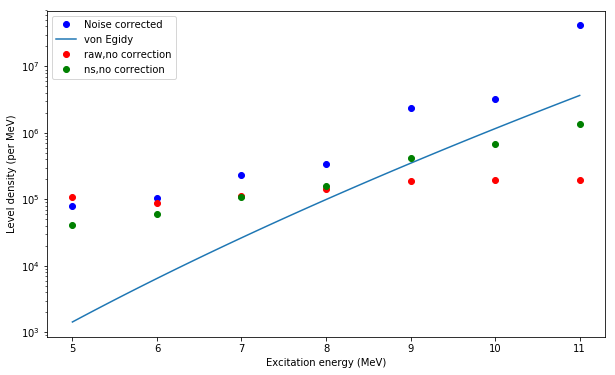

In [34]:
rholist=[]
for i,(l,h) in enumerate(binlist):
    bin=spt.Bin(bins.data,l,h)
    energy=bin.Eoffset
    data=bin.acnar
    alpha=2.4
    initialD=data[0]*(2.0*np.sqrt(np.pi)*sig)/alpha
    ndata=len(data)
    params=lmfit.Parameters()
    params.add('D',value=initialD, min=0.0)
    params.add('sign',value=sign,min=0.0, vary=False)
    params.add('sigw',value=sigw,min=0.0,vary=False)
    params.add('sigx',value=sigx,vary=False)
    noise=bin.get_noise_correction(sigsmn, sigsm)
    uncert=np.linspace(data[0]/10,data[0]/5,ndata)
    ACfx=(data-noise)*np.exp(-energy**2/(2.0*sigx**2))
    #ACfx=data*np.exp(-energy**2/(2.0*sigx**2))
    #initial=1.0
    #popt,pcov=curve_fit(fitf2, Xac, ACf, p0=[initial,sig])
    #sig=popt[1]
    #popt[0]*=initialD
    minner=lmfit.Minimizer(fitforlm, params, fcn_args=(energy,ACfx),
                           fcn_kws={'unc':uncert})
    result=minner.minimize()
    #lmfit.printfuncs.report_fit(result.params)
    p=result.params.valuesdict()
    D=ACfx[0]/spt.ACtheory(de,sign,sigw,alpha,1.0)
    rho=1.0/D#p['D']
    elo,ehi=bins.get_bin_limits(i)
    en=(elo+ehi)/2
    rholist.append((en,rho))
rholist=np.array( rholist )
print(np.shape(rholist))
e=rholist.T[0]
rho=rholist.T[1]
# theory
Eth=np.linspace(5.0,11.0)
Z,N=62,154-62
Spin=1.0
rhoth=ldn.LevelDenvonEgidy(Eth, Z, N, Spin)
# plot
plt.figure(figsize=(10,6))
plt.semilogy(e,rho,'bo',label="Noise corrected")
plt.semilogy(Eth,rhoth,label="von Egidy")
plt.semilogy(eAR,rhoAR,'ro',label="raw,no correction")
plt.semilogy(eOrig,rhoOrig,'go',label="ns,no correction")
plt.xlabel("Excitation energy (MeV)")
plt.ylabel("Level density (per MeV)")
plt.legend(loc=2)
plt.show()

A check on all the raw spectra in these bins.

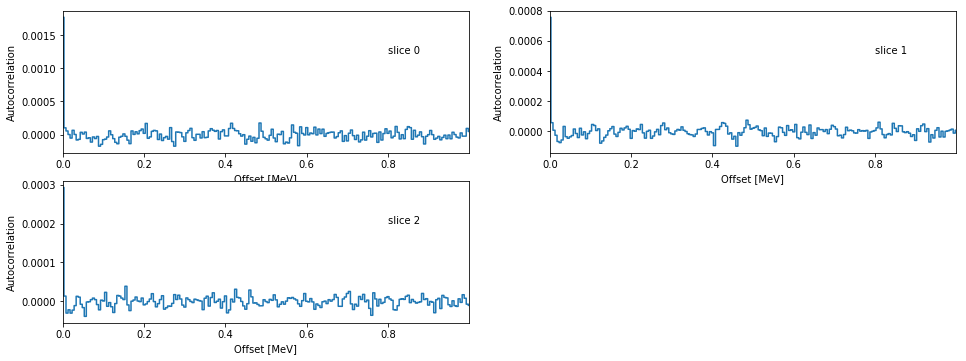

In [19]:
plt.figure(figsize=(16,12))
for i,(l,h) in enumerate(binlist):
    bin=spt.Bin(bins.data,l,h)
    energy=bin.Eoffset
    data=bin.acnar
    plt.subplot(4,2,i+1)
    plt.plot(energy,bin.acraw, drawstyle='steps-mid')
    yl,yh=plt.ylim()
    plt.xlim(0.0,energy[-1]/4)
    plt.text(0.8,0.7,"slice %d"%(i),transform=plt.gca().transAxes)
    plt.xlabel("Offset [MeV]")
    plt.ylabel("Autocorrelation")
plt.show()

Q: Is there really some effect there?

In [68]:
np.sqrt(2.0*np.log(2.0))

1.1774100225154747